In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# YAYMNet crudo
## Inputs
The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as mono 16 kHz samples in the range [-1.0, +1.0]. Internally, we frame the waveform into sliding windows of length 0.96 seconds and hop 0.48 seconds, and then run the core of the model on a batch of these frames.

In [3]:
yamnet_model_handle = 'C:/Users/Camilo/Downloads/yamnet_1/'
yamnet_model = hub.load(yamnet_model_handle)

In [4]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row['display_name'])
    return class_names

class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [5]:
class_names

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart murmur',
 'Cheering',
 'Applause',
 'Chatter',
 'Crowd',
 'Hubbub, speech noise, speech babble',
 'Children playing'

## Outputs
Assume that the input batch size is N frames after performing the framing described in the Inputs section above.

The model returns a 3-tuple (scores, embeddings, log_mel_spectrogram) where

- scores is a float32 Tensor of shape (N, 521) containing the per-frame predicted scores for each of the 521 classes in the AudioSet ontology that are supported by YAMNet. See below for how to map from column index to class name.
- embeddings is a float32 Tensor of shape (N, 1024) containing per-frame embeddings, where the embedding vector is the average-pooled output that feeds into the final classifier layer.
- log_mel_spectrogram is a float32 Tensor representing the log mel spectrogram of the entire waveform. These are the audio features passed into the model and have shape (num_spectrogram_frames, 64) where num_spectrogram_frames is the number of frames produced from the waveform by sliding a spectrogram analysis window of length 0.025 seconds with hop 0.01 seconds, and 64 represents the number of mel bins. See our GitHub repository for more detail.

In [6]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Prueba con un wav armado

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


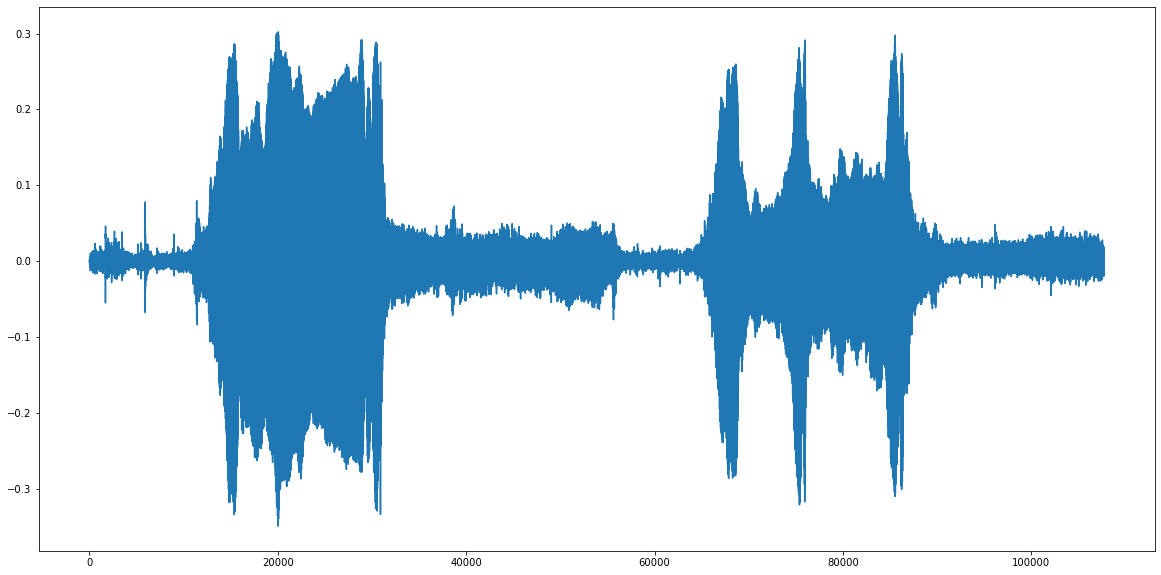

In [7]:
testing_wav_file_name = './test_data/miaow_16k.wav'
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(testing_wav_data)

In [8]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


In [9]:
m = tf.argmax(scores, axis=1).numpy()
s = tf.reduce_max(scores, axis=1).numpy()

In [10]:
threshold = 0.6
mclass = np.unique(m[s>threshold])

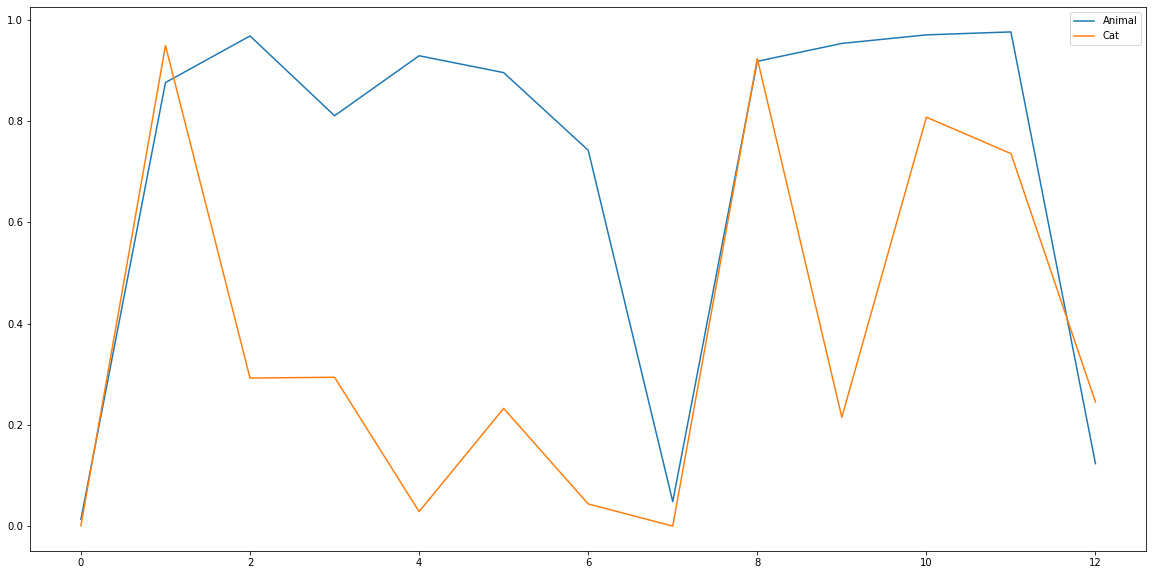

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
for c in mclass:
    ax.plot(scores[:,c],label=class_names[c])
ax.legend()    
#display.Audio(testing_wav_data,rate=16000)

## Prueba con los PCM de Sentinel

In [14]:
record_dir = './test_data/'
files = os.listdir(record_dir)
files_data = list(filter(lambda k: ('.pcm' in k), files))
nbytes = 2
nchan = 2

In [15]:
len(files_data)

10

In [16]:
def load_pcm48k(filename):
    nbytes = 2
    nchan = 2
    nmax = 2**(nbytes*8-1)
    dump = np.fromfile(filename, dtype='u1', count=-1)
    dump = np.delete(dump,np.arange(0,dump.size,3))
    nsamples=dump.shape[0]//(nchan*nbytes)
    data=np.reshape(dump.view(np.int16)/nmax,(nsamples,nchan)).astype('float32')
    tdata = tf.convert_to_tensor(data[:,0])
    tdata = tfio.audio.resample(tdata, rate_in=48000, rate_out=16000)
    return tdata

./test_data//2021_05_19_00_52_57.pcm


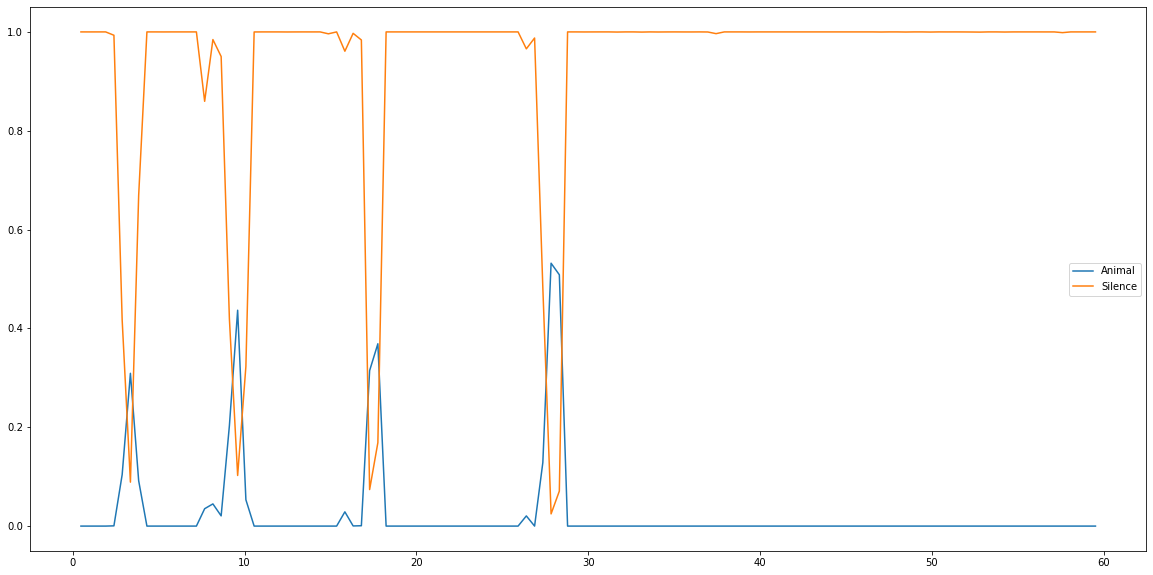

In [18]:
filename = record_dir + '/' + files_data[3]
print(filename)
tdata = load_pcm48k(filename)
scores, embeddings, spectrogram = yamnet_model(tdata)
m = tf.argmax(scores, axis=1).numpy()
s = tf.reduce_max(scores, axis=1).numpy()
threshold = 0.5
mclass = np.unique(m[s>threshold])
N, _ = scores.shape
t = np.arange(1,N+1)*0.48
fig, ax = plt.subplots(figsize=(20,10))
for c in mclass:
    ax.plot(t,scores[:,c],label=class_names[c])
ax.legend()    
display.Audio(tdata,rate=16000)

In [50]:
tfio.__version__

'0.19.1'

# Transfer Learning

## Descargo una base de datos para reentrenar la red

In [19]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [32]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


## Selecciono filtrando los datos para quedarme con las clases que quiero entrenar

In [33]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


Load the audio files and retrieve embeddings
Here you'll apply the load_wav_16k_mono and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape (N, 1024) where N is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the fold column to proper reflect these new rows.

The expanded fold column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [34]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## Extraigo los embeddings para las clases seleccionadas

In [35]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [36]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [37]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Armo mi modelo y lo evaluo

In [38]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

In [39]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [40]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 4s 26ms/step - loss: 0.4725 - accuracy: 0.8417 - val_loss: 0.1953 - val_accuracy: 0.8813
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 0.4773 - accuracy: 0.8667 - val_loss: 0.3711 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 0s 17ms/step - loss: 0.4009 - accuracy: 0.9021 - val_loss: 0.1961 - val_accuracy: 0.9187
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 0.3922 - accuracy: 0.9042 - val_loss: 0.2111 - val_accuracy: 0.9062
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 0.2008 - accuracy: 0.9271 - val_loss: 0.3204 - val_accuracy: 0.9187
Epoch 6/20
15/15 [==============================] - 0s 16ms/step - loss: 0.4608 - accuracy: 0.9167 - val_loss: 0.2083 - val_accuracy: 0.9125
Epoch 7/20
15/15 [==============================] - 0s 17ms/step - loss: 0.3580 - accuracy: 0.9208 - val_loss: 0.8000 - val_accuracy: 0.8625
Epoch 8/20
15

In [41]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 5ms/step - loss: 0.4128 - accuracy: 0.9000
Loss:  0.41275930404663086
Accuracy:  0.8999999761581421


In [42]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: cat
